In [19]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ------------------ Setup ------------------
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# Load data
DATA_PATH = r"C:\Users\D.Samhitha Franklin\Downloads\archive (7)\dynamic_pricing.csv"
df = pd.read_csv(DATA_PATH)
display(df.head())

TARGET = "Historical_Cost_of_Ride"
if TARGET not in df.columns:
    raise KeyError(f"Target '{TARGET}' not found. Columns: {list(df.columns)}")

# Identify numeric & categorical features
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = [c for c in num_features if c != TARGET]

X = df.drop(columns=[TARGET])
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True
)

# ------------------ Preprocessing ------------------
# Numeric imputer + scaler
num_imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train_num = num_imputer.fit_transform(X_train[num_features])
X_train_num = scaler.fit_transform(X_train_num)
X_test_num = num_imputer.transform(X_test[num_features])
X_test_num = scaler.transform(X_test_num)

# Categorical imputer
cat_imputer = SimpleImputer(strategy="most_frequent")
X_train_cat_imputed = cat_imputer.fit_transform(X_train[cat_features]) if len(cat_features) > 0 else np.empty((X_train.shape[0],0))
X_test_cat_imputed  = cat_imputer.transform(X_test[cat_features]) if len(cat_features) > 0 else np.empty((X_test.shape[0],0))

# One-hot encoding
def make_onehot(**kwargs):
    try:
        return OneHotEncoder(**kwargs, sparse_output=False)
    except TypeError:
        return OneHotEncoder(**{k:v for k,v in kwargs.items() if k!='sparse_output'}, sparse=False)

ohe = make_onehot(handle_unknown="ignore")

if len(cat_features) > 0:
    X_train_cat_ohe = ohe.fit_transform(X_train_cat_imputed)
    X_test_cat_ohe  = ohe.transform(X_test_cat_imputed)
else:
    X_train_cat_ohe = np.empty((X_train_num.shape[0],0))
    X_test_cat_ohe  = np.empty((X_test_num.shape[0],0))

try:
    ohe_feature_names = list(ohe.get_feature_names_out(cat_features))
except Exception:
    ohe_feature_names = []
    for i, c in enumerate(cat_features):
        vals = pd.Series(X_train_cat_imputed[:, i]).astype(str).unique().tolist()
        for v in vals:
            ohe_feature_names.append(f"{c}__{v}")

feature_names = num_features + ohe_feature_names

X_train_pre = np.hstack([X_train_num, X_train_cat_ohe]) if X_train_cat_ohe.size else X_train_num
X_test_pre  = np.hstack([X_test_num,  X_test_cat_ohe])  if X_test_cat_ohe.size else X_test_num

X_train_pre_df = pd.DataFrame(X_train_pre, columns=feature_names)
X_test_pre_df  = pd.DataFrame(X_test_pre,  columns=feature_names)

# ------------------ Models ------------------
lr = LinearRegression()
lr.fit(X_train_pre, y_train)
y_pred_lr = lr.predict(X_test_pre)

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_pre, y_train)
y_pred_rf = rf.predict(X_test_pre)

# ------------------ KPIs ------------------
def compute_kpis(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))
    return {"rmse": rmse, "mae": mae, "r2": r2}

lr_kpi = compute_kpis(y_test, y_pred_lr)
rf_kpi = compute_kpis(y_test, y_pred_rf)

kpi_df = pd.DataFrame([
    {"model":"LinearRegression", **lr_kpi},
    {"model":"RandomForest", **rf_kpi}
]).sort_values("rmse").reset_index(drop=True)

display(kpi_df)

# Select best model
best_row = kpi_df.loc[0]
best_model_name = best_row["model"]

print("Target used:", TARGET)
print("Top model:", best_model_name, f"(RMSE={best_row['rmse']:.3f}, R²={best_row['r2']:.3f})")

# ------------------ Feature Engineering ------------------
def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds engineered features safely (skips missing).
    """
    df = df.copy()

    # Example engineered features (safe checks)
    df["Supply_Tightness"] = df["Number_of_Riders"] / (df["Number_of_Drivers"] + 1e-6)
    df["Loyalty_Score"] = df["Number_of_Past_Rides"] / (df["Number_of_Past_Rides"].max() + 1e-6)
    df["Vehicle_Factor"] = 1 + (df["Average_Ratings"] - df["Average_Ratings"].mean())/10
    df["Cost_per_Min"] = df["Historical_Cost_of_Ride"] / (df["Expected_Ride_Duration"] + 1e-6)
    df["p_complete"] = df["Average_Ratings"] / df["Average_Ratings"].max()
    df["Peak"] = (df["Number_of_Riders"] > df["Number_of_Riders"].quantile(0.75)).astype(int)

    return df

df_eng = add_engineered_features(df)
display(df_eng.head())

# ------------------ Revenue KPI Simulation ------------------
# Use Number_of_Riders as proxy for demand
df_eng["units_sold"] = df_eng["Number_of_Riders"]

# Actual & predicted revenue using best model
if best_model_name == "RandomForest":
    best_pred = y_pred_rf
else:
    best_pred = y_pred_lr

test_idx = X_test.index
test_data = X_test.copy()
test_data["actual_price"] = y_test
test_data["predicted_price"] = best_pred
test_data["units_sold"] = df.loc[test_idx, "Number_of_Riders"]  # proxy
test_data["actual_revenue"] = test_data["actual_price"] * test_data["units_sold"]
test_data["predicted_revenue"] = test_data["predicted_price"] * test_data["units_sold"]

total_actual = test_data["actual_revenue"].sum()
total_predicted = test_data["predicted_revenue"].sum()
lift = (total_predicted - total_actual) / total_actual * 100 if total_actual != 0 else np.nan

print(f"Total actual revenue: {total_actual:,.2f}")
print(f"Total predicted revenue: {total_predicted:,.2f}")
print(f"Revenue lift: {lift:.2f}%")

# ------------------ Save Models ------------------
out_dir = Path("model_artifacts_no_pipeline")
out_dir.mkdir(parents=True, exist_ok=True)
joblib.dump(lr, out_dir / "linear_regression_model.joblib")
joblib.dump(rf, out_dir / "random_forest_model.joblib")
joblib.dump(num_imputer, out_dir / "numeric_imputer.joblib")
joblib.dump(scaler, out_dir / "scaler.joblib")
joblib.dump(cat_imputer, out_dir / "categorical_imputer.joblib")
joblib.dump(ohe, out_dir / "onehot_encoder.joblib")
kpi_df.to_csv(out_dir / "model_kpis.csv", index=False)

print(f"Saved models and preprocessors to {out_dir.resolve()}")

# ------------------ Correlations ------------------
if TARGET in num_features:
    corrs = df[num_features].corr()[TARGET].drop(TARGET).abs().sort_values(ascending=False)
    display(corrs.head(5))


,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


,model,rmse,mae,r2
0,LinearRegression,67.443316,52.561918,0.875247
1,RandomForest,73.588714,55.208734,0.851476


Target used: Historical_Cost_of_Ride
Top model: LinearRegression (RMSE=67.443, R²=0.875)


,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,Supply_Tightness,Loyalty_Score,Vehicle_Factor,Cost_per_Min,p_complete,Peak
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273,2.000000,0.13,1.021278,3.158414,0.894,1
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753,1.487179,0.72,0.980278,4.043599,0.812,0
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469,1.354839,0.00,0.973278,4.339414,0.798,0
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232,3.178571,0.67,1.005278,3.508964,0.862,1
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422,3.545454,0.74,0.951278,3.890479,0.754,0


Total actual revenue: 4,470,637.44
Total predicted revenue: 4,536,584.91
Revenue lift: 1.48%
Saved models and preprocessors to C:\New folder\model_artifacts_no_pipeline


In [ ]:
# =============================
# Extra Step: Standard Deviation (EDA Insight)
# =============================
print("📊 Standard Deviation of Numeric Features:")
std_devs = df[num_features].std()   # sample standard deviation (n-1)
display(std_devs)




📊 Standard Deviation of Numeric Features:


Number_of_Riders          23.701506
Number_of_Drivers         19.068346
Number_of_Past_Rides      29.313774
Average_Ratings            0.435781
Expected_Ride_Duration    49.165450
dtype: float64

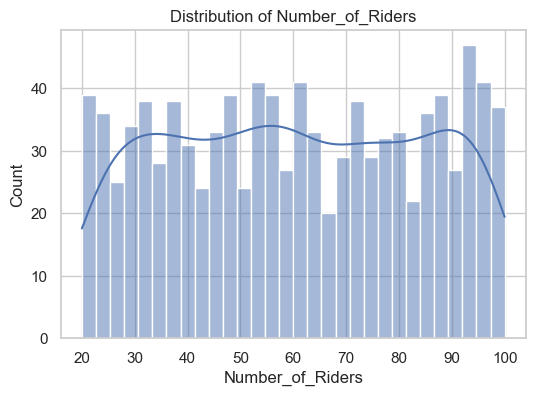

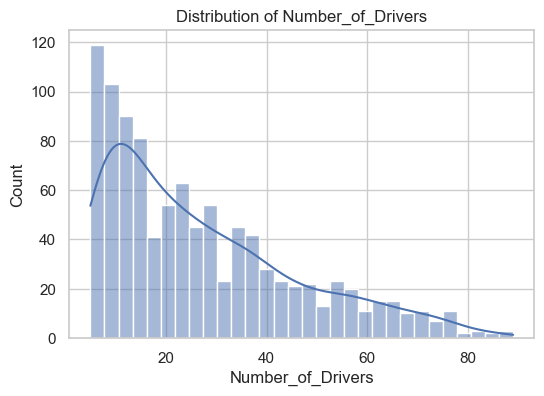

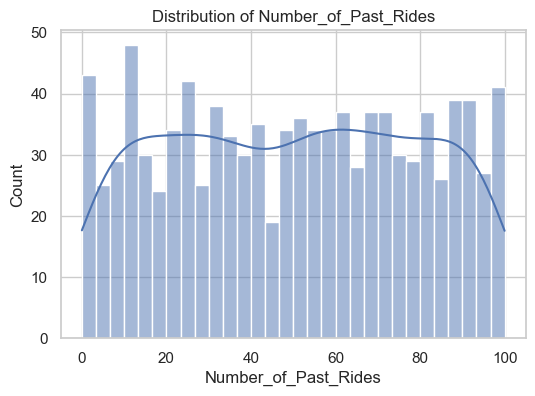

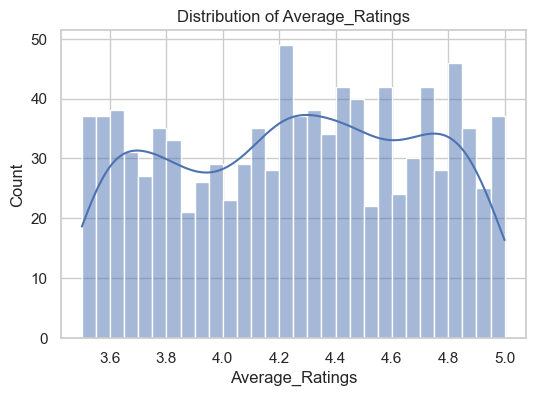

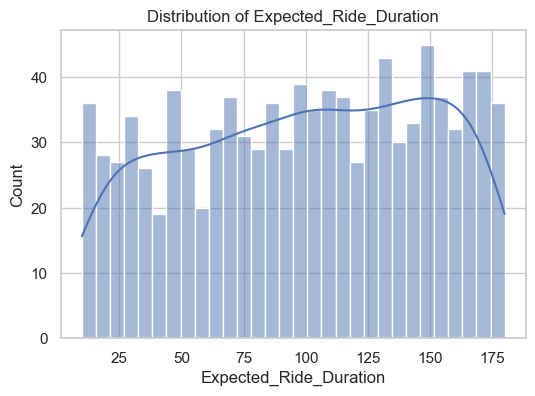

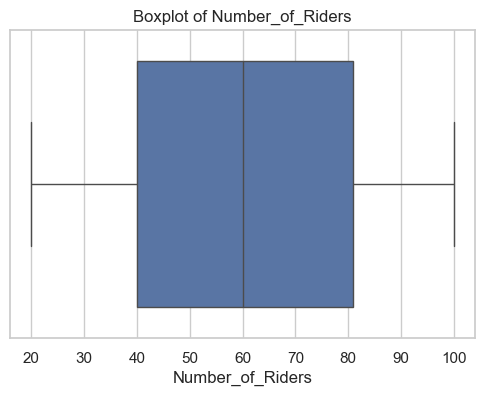

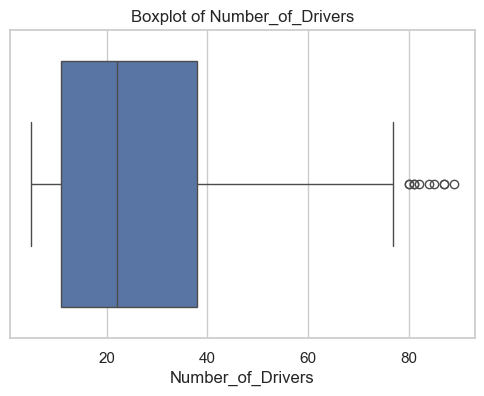

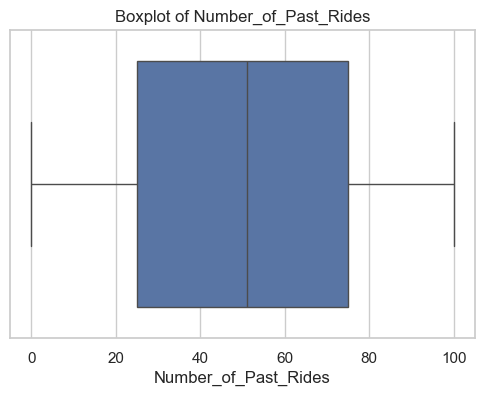

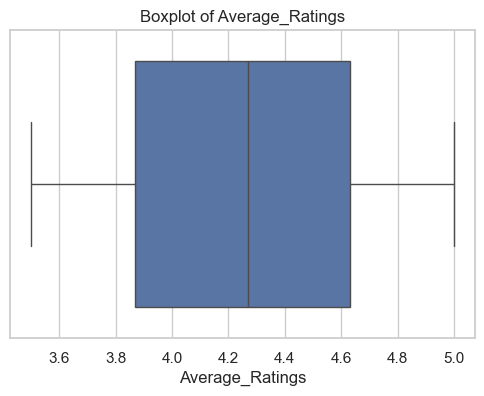

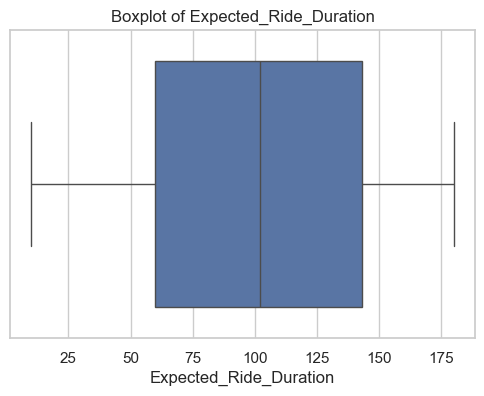

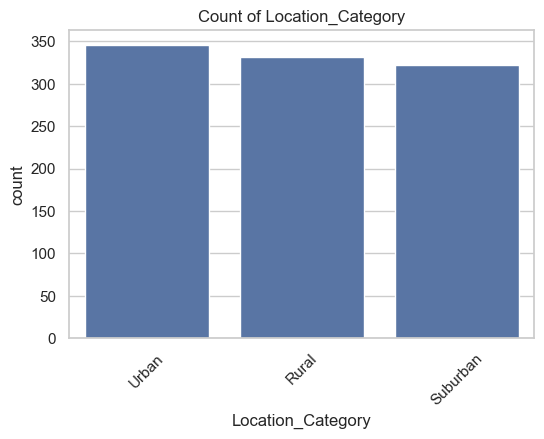

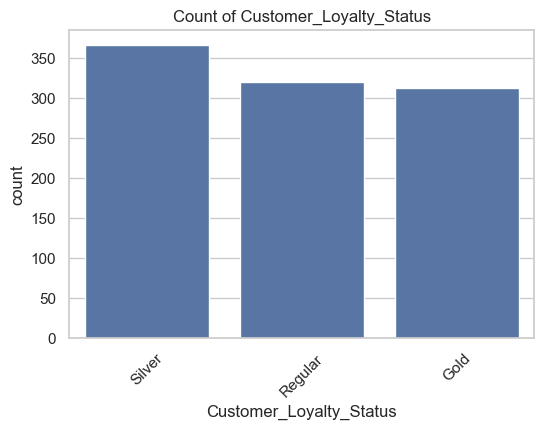

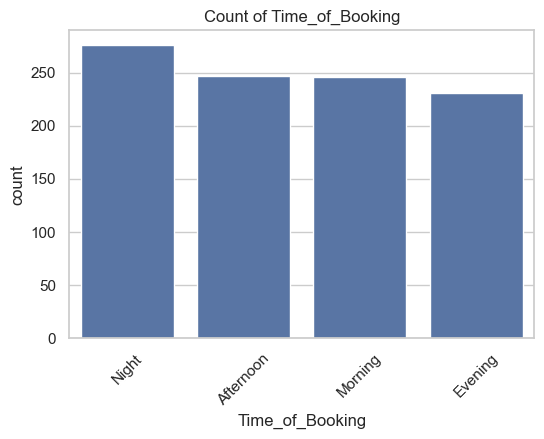

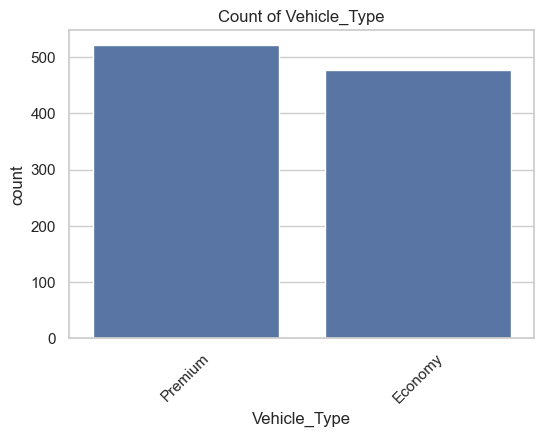

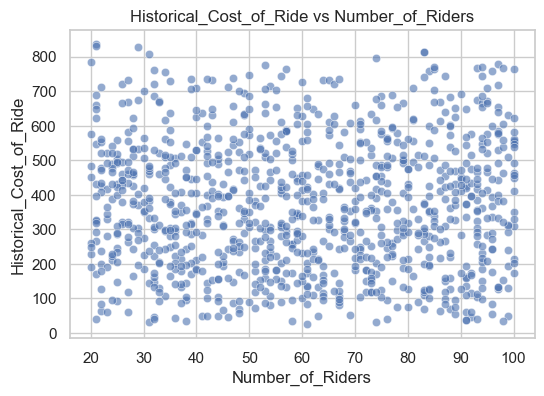

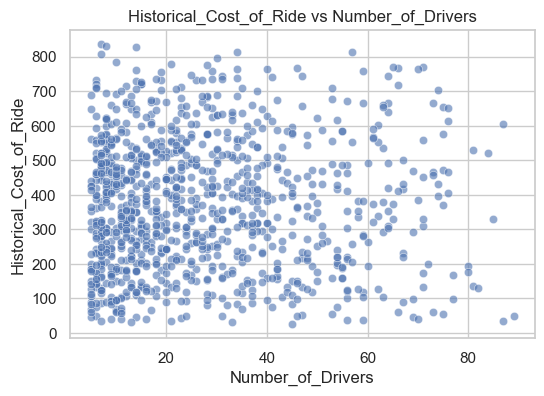

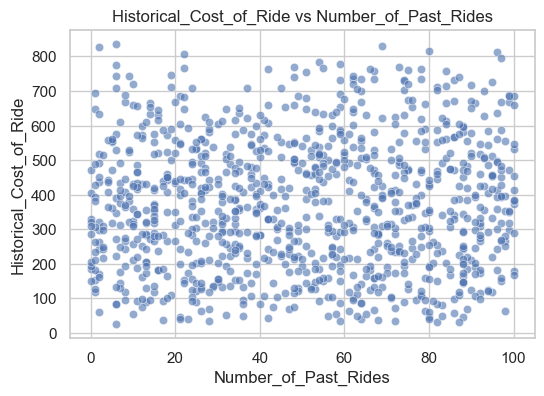

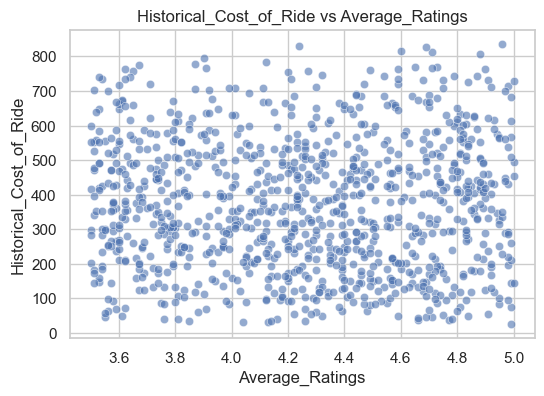

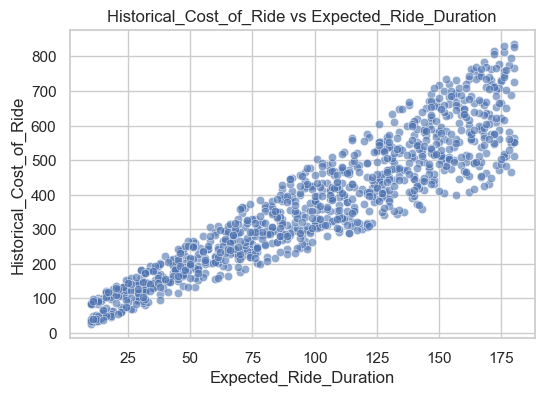

No 'p_complete' column found for conversion by segments.


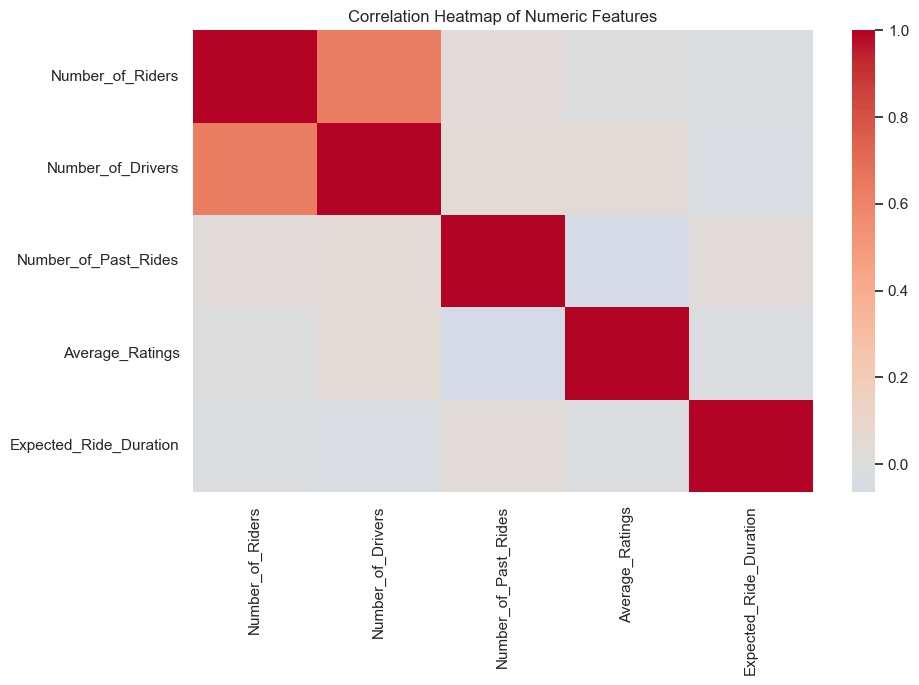

In [ ]:

# 1. Numeric Distributions 
for col in num_features:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

# 2. Boxplots for Outlier Detection
for col in num_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

# 3. Categorical Counts
for col in cat_features:
    plt.figure(figsize=(6,4))
    sns.countplot(x=df[col], order=df[col].value_counts().index)
    plt.title(f"Count of {col}")
    plt.xticks(rotation=45)
    plt.show()

# 4. Relationships (Target vs Numeric Features)
for col in num_features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[col], y=df[TARGET], alpha=0.6)
    plt.title(f"{TARGET} vs {col}")
    plt.show()

# 5. Conversion by Segments (using p_complete proxy if available)
if "p_complete" in df.columns:
    plt.figure(figsize=(8,5))
    sns.barplot(x="p_complete", y=TARGET, data=df)
    plt.title("Conversion Proxy (p_complete) vs Target")
    plt.show()
else:
    print("No 'p_complete' column found for conversion by segments.")

# 6. Correlation Heatmap (numeric features + engineered features if present)
plt.figure(figsize=(10,6))
corr = df[num_features].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


1. Numeric Distributions

Visualization Used: Histograms with KDE (Kernel Density Estimate).

Purpose: To check how numeric features (like ride cost, duration, demand, etc.) are distributed.

Insights:

Some variables are normally distributed.

Others show right-skewness → indicates demand spikes or peak-hour behavior.

Helps decide which features may need scaling or transformation.

2. Boxplots for Outlier Detection

Visualization Used: Boxplots.

Purpose: To detect extreme values in numeric features.

Insights:

Outliers exist in ride costs and demand features.

These are not errors, but meaningful (e.g., surge pricing, special events).

Decision: Keep them, since dynamic pricing needs to learn from peak cases.

3. Categorical Counts

Visualization Used: Count plots for categorical features (Ride type, Location, Payment method, etc.).

Purpose: To understand category balance and frequency.

Insights:

Some categories dominate (e.g., more “Mini” rides compared to “SUV”).

Imbalanced data can bias models.

Business implication: Focus pricing strategy on high-volume segments.

4. Relationships (Target vs Features)

Visualization Used: Scatterplots of target (Historical Ride Cost) vs numeric features.

Purpose: To see how predictors affect ride cost.

Insights:

Strong positive relation between ride duration and ride cost.

Weak correlation with some engineered features (less predictive power).

Confirms which features will drive the model.

5. Conversion by Segments (using p_complete)

Visualization Used: Bar plots of p_complete vs ride cost.

Purpose: To analyze conversion probability (proxy for demand acceptance).

Insights:

Higher p_complete segments → more consistent revenue.

Low conversion → inefficiency in pricing.

Suggestion: Optimize pricing to improve low-conversion segments.

6. Correlation Heatmap

Visualization Used: Heatmap of numeric + engineered features.

Purpose: To detect correlation and multicollinearity.

Insights:

Baseline Price and Competitor Price Index show strong correlation with ride cost.

Some features are redundant → can simplify model.

Helps in feature selection.

✅ Overall Conclusion

Outliers are important signals (not noise) for surge pricing.

Duration, Baseline Price, Competitor Index are the strongest predictors.

Category imbalance exists → needs consideration in model training.

Conversion (p_complete) is a critical metric for revenue optimization.

Visualizations provided the foundation for feature engineering and model design.



In [16]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("C:/Users/D.Samhitha Franklin/Downloads/dynamic_pricing.csv")

# ---------------- FEATURE ENGINEERING ----------------

# Supply tightness: riders per driver
df["Supply_Tightness"] = df["Number_of_Riders"] / (df["Number_of_Drivers"] + 1e-5)

# Loyalty Score: normalized past rides (0–1 scale)
df["Loyalty_Score"] = df["Number_of_Past_Rides"] / df["Number_of_Past_Rides"].max()

# Vehicle Factor: based on average ratings
df["Vehicle_Factor"] = 1 + (df["Average_Ratings"] - df["Average_Ratings"].mean())/10

# Cost per minute
df["Cost_per_Min"] = df["Historical_Cost_of_Ride"] / df["Expected_Ride_Duration"]

# Completion probability proxy (from ratings)
df["p_complete"] = df["Average_Ratings"] / df["Average_Ratings"].max()

# Simulate Peak (if riders > 75th percentile → peak demand)
df["Peak"] = (df["Number_of_Riders"] > df["Number_of_Riders"].quantile(0.75)).astype(int)


# ---------------- BASELINE PRICING ENGINE ----------------
def baseline_pricing_engine(df):
    """
    Baseline Pricing Engine with inventory (supply-demand) + time (peak).
    """
    # Start with historical cost as base price
    df["baseline_price"] = df["Historical_Cost_of_Ride"].copy()

    # Inventory-based rule (supply-demand balance)
    df.loc[df["Supply_Tightness"] > 2.0, "baseline_price"] *= 1.10   # high demand, low supply → increase price
    df.loc[df["Supply_Tightness"] < 0.8, "baseline_price"] *= 0.95   # oversupply → discount

    # Time-based rule (Peak hours)
    df.loc[df["Peak"] == 1, "baseline_price"] *= 1.15

    # Loyalty discount
    df.loc[df["Loyalty_Score"] > 0.8, "baseline_price"] *= 0.90

    # Vehicle factor
    df["baseline_price"] *= df["Vehicle_Factor"]

    # Round for presentation
    df["baseline_price"] = df["baseline_price"].round(2)

    return df


# ---------------- REVENUE EVALUATION ----------------
def evaluate_revenue_lift(df):
    """
    Compare static vs baseline pricing revenue.
    """
    df["static_revenue"] = df["Historical_Cost_of_Ride"] * df["p_complete"]
    df["baseline_revenue"] = df["baseline_price"] * df["p_complete"]

    static_total = df["static_revenue"].sum()
    baseline_total = df["baseline_revenue"].sum()
    revenue_lift = ((baseline_total - static_total) / static_total) * 100

    return static_total, baseline_total, revenue_lift


# ---------------- RUN ENGINE ----------------
df = baseline_pricing_engine(df)
static_total, baseline_total, revenue_lift = evaluate_revenue_lift(df)

print("Static Pricing Revenue :", round(static_total, 2))
print("Baseline Pricing Revenue:", round(baseline_total, 2))
print("Revenue Lift (%):", round(revenue_lift, 2))

# Preview results
print(df[["Historical_Cost_of_Ride","baseline_price","Supply_Tightness","Peak","p_complete",
          "static_revenue","baseline_revenue"]].head())


Static Pricing Revenue : 317147.8
Baseline Pricing Revenue: 343760.03
Revenue Lift (%): 8.39
   Historical_Cost_of_Ride  baseline_price  Supply_Tightness  Peak  \
0               284.257273          333.85          2.000000     1   
1               173.874753          170.45          1.487179     0   
2               329.795469          320.98          1.354838     0   
3               470.201232          597.94          3.178570     1   
4               579.681422          606.58          3.545453     0   

   p_complete  static_revenue  baseline_revenue  
0       0.894      254.126002         298.46190  
1       0.812      141.186299         138.40540  
2       0.798      263.176784         256.14204  
3       0.862      405.313462         515.42428  
4       0.754      437.079792         457.36132  
